In [1]:
import stlearn as st
from pathlib import Path
st.settings.set_figure_params(dpi=180)
import pandas as pd
import math
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import sys



# Import Data

### Get Sample to run

In [2]:
samples =["VLP78_A",  "VLP78_D",  "VLP79_A",  "VLP79_D",  "VLP80_A",  "VLP80_D",  "VLP81_A",  "VLP82_A",  "VLP82_D",  "VLP83_A",  "VLP83_D"]
i = int(sys.argv[1])
sample = samples[i]

ValueError: invalid literal for int() with base 10: '-f'

In [5]:
DATA_PATH = "I:/GMLSC1-Q2051/Pfizer/Visium/RAW_DATA/Pfizer/"
OUT_PATH = "I:/GML001-Q1851/Andrew_C/Pfizer/Visium/"

data = st.Read10X(DATA_PATH+sample+"/outs/")

C:\Users\uqacause\AppData\Local\anaconda3\envs\stlearn\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\uqacause\AppData\Local\anaconda3\envs\stlearn\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Add Seurat generated Label Transfer 

In [6]:
df = pd.read_csv(filepath_or_buffer= OUT_PATH + sample +"/label_transfer/"+ sample+ "_label_transfer.csv")
df.set_index("Unnamed: 0", inplace = True)
data.obs["label_transfer"] = df["predicted.id"].astype('category')



In [7]:
### Set up colour dictionary for all plots
color_dict = { "Cancer Epithelial":"#b3b1a6",
  "Plasmablasts": "#24d7ff",     
  "B-cells" : "#33A02C",      
  "T-cells" :  "#E31A1C",     
  "CAFs" : "#FB9A99",          
  "Myeloid" :  "#1F78B4" ,        
  "Endothelial": "#E8d9fc",
  "PVL": "#FF7F00"                  
}

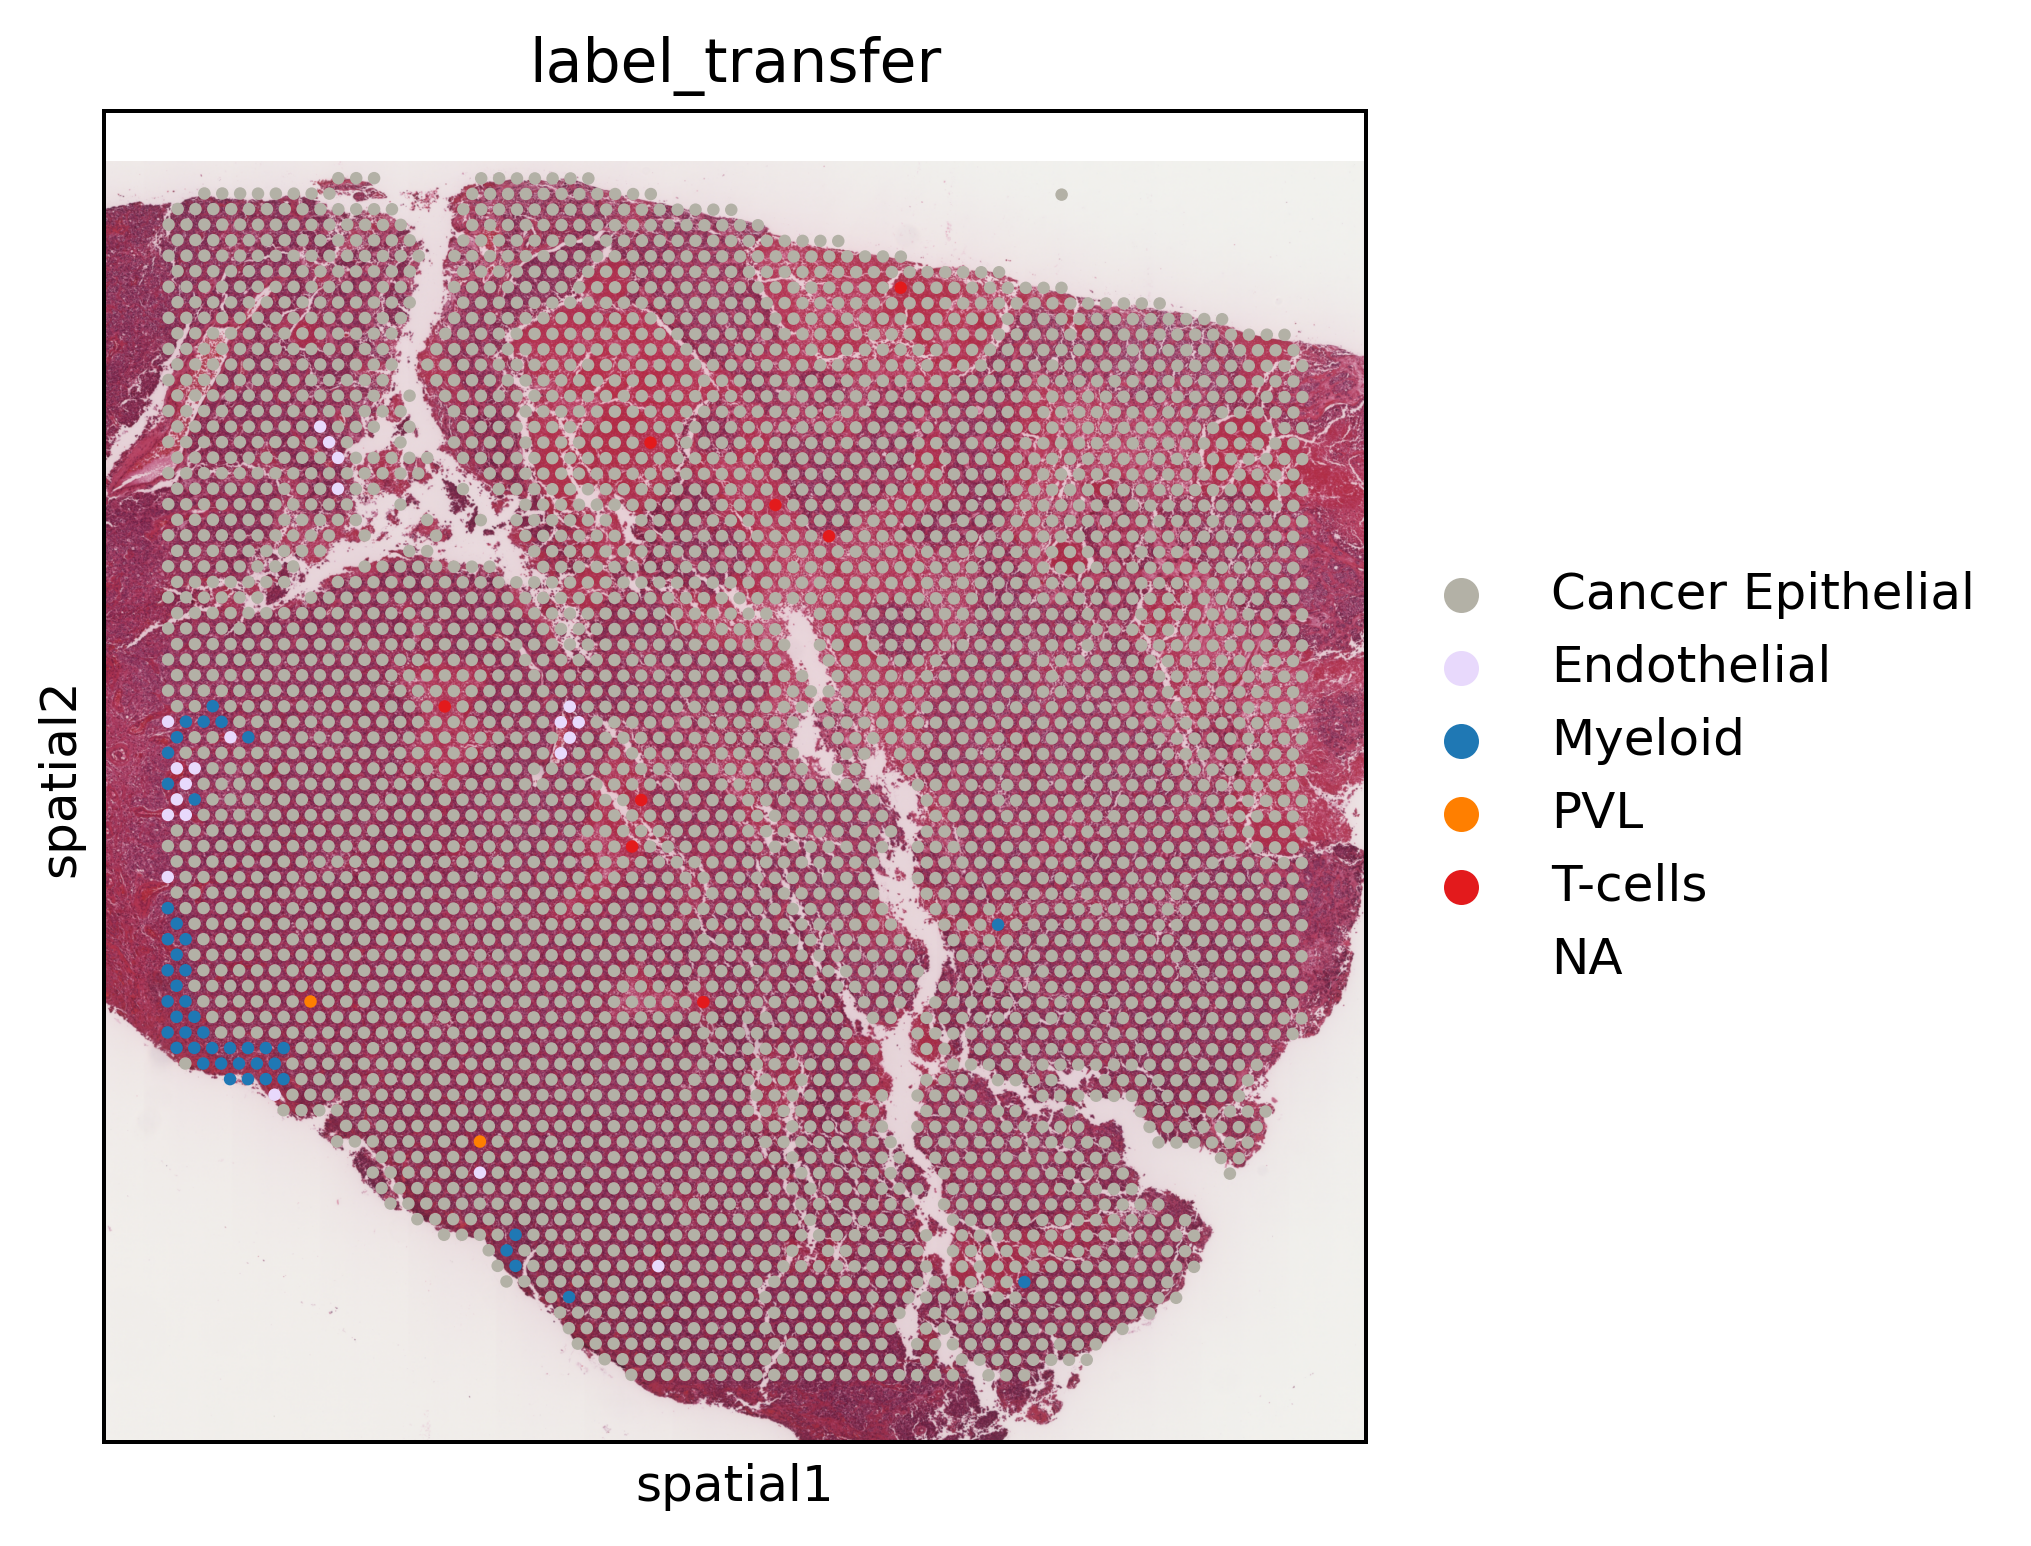

In [8]:
#Plot data
sc.pl.spatial(data, color=['label_transfer'], palette=color_dict)

# Subset data to just define the Tumour Core

### 'Cancer Epithelial' + 'CAFs'

In [9]:
core = data.obs['label_transfer'].isin(["Cancer Epithelial","CAFs"])
core_data = data[core,:]

In [7]:
#clustered_samples = {}

#def run_clustering(adata):
#    sc.pp.normalize_total(adata, target_sum=1e4)
#    #sc.pp.log1p(adata)
#    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
#   sc.tl.leiden(adata, resolution= 0.2)
#    sc.tl.paga(adata)
#    sc.pl.paga(adata, plot=False)
#    sc.tl.umap(adata, init_pos='paga')
#    return(adata)

#for sample,data in lt_data.items():
#    new_data = run_clustering(data)
#    clustered_samples[sample] = new_data

# Run Cell Cell Interactions within Tumour core

In [18]:
## Make file save directory
lr_file_path = OUT_PATH + sample + "/lr_analysis/"
stlearn_dir = Path(lr_file_path)

# Check if the directory already exists
if not stlearn_dir.exists():
    # Create the directory
    stlearn_dir.mkdir()


In [10]:
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')

st.tl.cci.run(core_data, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=10000, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=None, # Number of CPUs for parallel. If None, detects & use all available.
                  ) 

Calculating neighbours...
5 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 869 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|███████████████████████████████████████████ [ time left: 00:00 ]



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [15]:
st.tl.cci.adj_pvals(core_data, correct_axis='spot',pval_adj_cutoff=0.05, adj_method='fdr_bh')

Updated adata.uns[lr_summary]
Updated adata.obsm[lr_scores]
Updated adata.obsm[lr_sig_scores]
Updated adata.obsm[p_vals]
Updated adata.obsm[p_adjs]
Updated adata.obsm[-log10(p_adjs)]


## Plots Cell-Cell Interactions

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
st.pl.lr_summary(core_data, n_top=60, figsize=(10,3), show = False, ax=ax);
plt.savefig(lr_file_path+sample+"_top60_lrpairs.png", dpi=300)
plt.close()

In [41]:
best_lr = core_data.uns['lr_summary'].index.values[0]
stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']

fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(core_data, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i]);
    axes[i].set_title(f'{best_lr} {stat}')
plt.savefig(lr_file_path+sample+"_top_lrpair_spatial.png", dpi=300)
plt.close()

## Save Data

In [99]:
core_data_copy = core_data.copy()

In [100]:
core_data_copy.uns["lrfeatures"] = core_data_copy.uns["lrfeatures"].astype(str)

In [101]:
core_data_copy.write_h5ad(lr_file_path+sample+"_lr_data.h5ad")